<a href="https://colab.research.google.com/github/Artemiy2708/ML/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%F0%9F%90%AFAF_Shine_Astashkin%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small><hr style="margin:0;background-color:silver">

# **[🏆💎Diamonds](https://www.kaggle.com/c/jan-24-diamonds/rules)**

See [**instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running and naming your Colab notebooks.

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/kaggle

[Errno 2] No such file or directory: '/content/drive/MyDrive/kaggle'
/content


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                  # Alternative location of kaggle.json (without a connection to Google Drive)
#!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v jan-24-diamonds          # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
# !kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: jan-24-diamonds
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 369 ms, sys: 64.2 ms, total: 434 ms
Wall time: 892 ms


In [ ]:
import pandas as pd
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

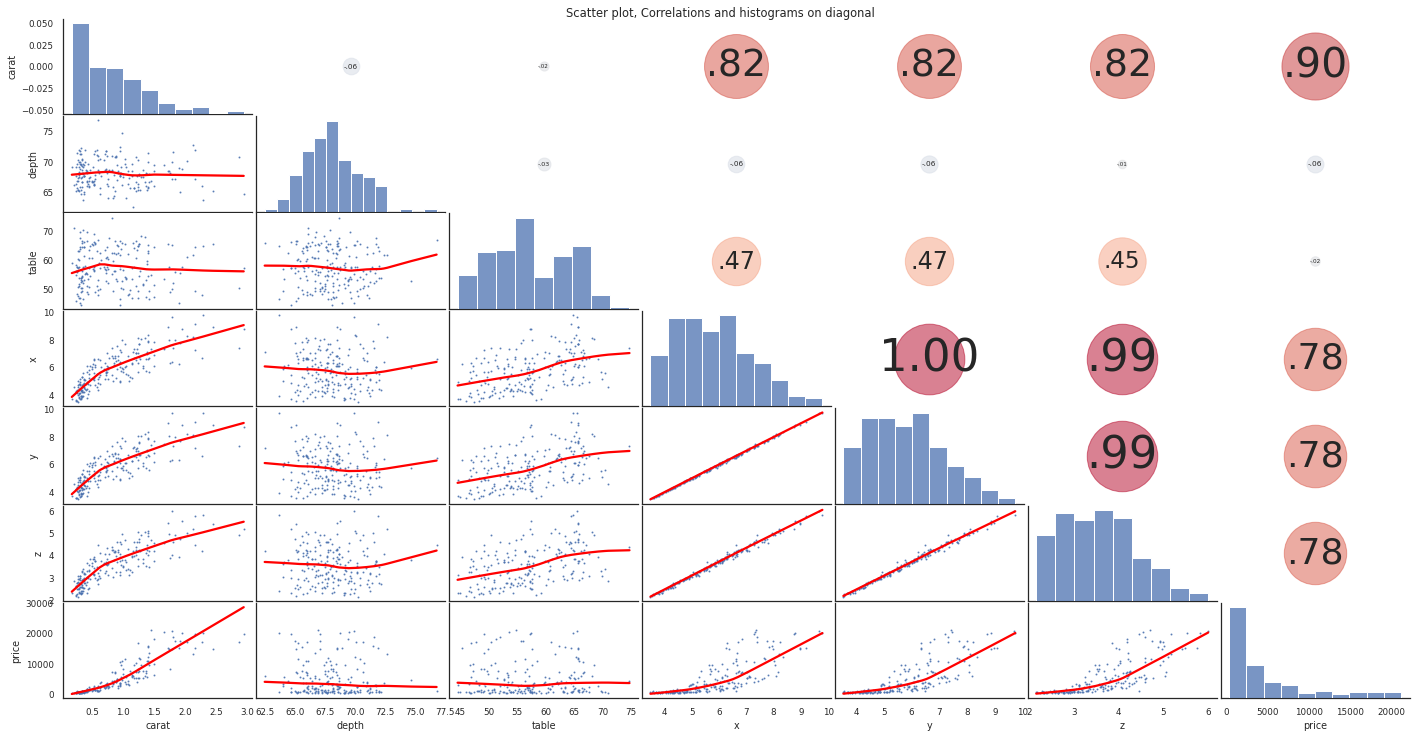

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
1. Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Perhaps something in EDA or prior experience lead you to these)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

We started with analysing given data. Then we checked for null values of columns 'x,y,z' and dropped them out of the whole sample - nonvalid data, as well as outliers , using IQR formula. After this, we built correlation matrix to see the correlation between parameters(numerical) and made graphs (scatterplots and boxplots) between each parameter and price to decide which parameter should be used in our model to reach effectiveness(for both categorical and numerical variables). We saw that each that categorical variables , depending on value has different means , so we should not drop them - so we just we did one hot encoding for them, to be able to work with them. Based on this, we dropped improper columns (color, cut, clarity)(as we have instead of them other dummy varibles) and created new feature object such as volume. Then we see that some variables have normal distribution, some lognormal - carat, price, we made them  to normal distribution to increase score.

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

We tried simple Linear Regression, Lasso and RIdge. Lasso worked awful for mae improving, linear Regression and ridge on the same level. We don't know why Lasso did not worked, as it is L1 regulirization what seams a better reglation when metric we want to optimize is mae. We did not tune hyperparametres,as did not study them on seminars. effectnes of elements were explained in the previous section.

**Student's answer:**

Below is a baseline model that produces the result on Kaggle leaderboard (LB).

In [ ]:
import pandas as pd
df = pd.read_csv('XY_diamonds.csv')

In [ ]:
df_predict=df[df['price'].isna()]

In [ ]:
df_new=df[df['price'].notnull()]

In [ ]:
#df_new.isna().sum().sum()


In [ ]:
#df_new.info()

In [ ]:
#df_new.describe()

In [ ]:
q1_carat=df_new['carat'].quantile(0.25)-1.5*(df_new['carat'].quantile(0.75)-df_new['carat'].quantile(0.25))
q3_carat=df_new['carat'].quantile(0.75)+1.5*(df_new['carat'].quantile(0.75)-df_new['carat'].quantile(0.25))
df_new=df_new.loc[(df_new['carat']>=q1_carat) & (df_new['carat']<=q3_carat)]

q1_depth=df_new['depth'].quantile(0.25)-1.5*(df_new['depth'].quantile(0.75)-df_new['depth'].quantile(0.25))
q3_depth=df_new['depth'].quantile(0.75)+1.5*(df_new['depth'].quantile(0.75)-df_new['depth'].quantile(0.25))
df_new=df_new.loc[(df_new['depth']>=q1_depth) & (df_new['depth']<=q3_depth)]

q1_table=df_new['table'].quantile(0.25)-1.5*(df_new['table'].quantile(0.75)-df_new['table'].quantile(0.25))
q3_table=df_new['table'].quantile(0.75)+1.5*(df_new['table'].quantile(0.75)-df_new['table'].quantile(0.25))
df_new=df_new.loc[(df_new['table']>=q1_table) & (df_new['table']<=q3_table)]

q1_x=df_new['x'].quantile(0.25)-1.5*(df_new['x'].quantile(0.75)-df_new['x'].quantile(0.25))
q3_x=df_new['x'].quantile(0.75)+1.5*(df_new['x'].quantile(0.75)-df_new['x'].quantile(0.25))
df_new=df_new.loc[(df_new['x']>=q1_x) & (df_new['x']<=q3_x) & (df_new['x']!=0)]

q1_y=df_new['y'].quantile(0.25)-1.5*(df_new['y'].quantile(0.75)-df_new['y'].quantile(0.25))
q3_y=df_new['y'].quantile(0.75)+1.5*(df_new['y'].quantile(0.75)-df_new['y'].quantile(0.25))
df_new=df_new.loc[(df_new['y']>=q1_y) & (df_new['y']<=q3_y)& (df_new['y']!=0)]

q1_z=df_new['z'].quantile(0.25)-1.5*(df_new['z'].quantile(0.75)-df_new['z'].quantile(0.25))
q3_z=df_new['z'].quantile(0.75)+1.5*(df_new['z'].quantile(0.75)-df_new['z'].quantile(0.25))
df_new=df_new.loc[(df_new['z']>=q1_z) & (df_new['z']<=q3_z) & (df_new['z']!=0)]

q1_price=df_new['price'].quantile(0.25)-1.5*(df_new['price'].quantile(0.75)-df_new['price'].quantile(0.25))
q3_price=df_new['price'].quantile(0.75)+1.5*(df_new['price'].quantile(0.75)-df_new['price'].quantile(0.25))
df_new=df_new.loc[(df_new['price']>=q1_price) & (df_new['price']<=q3_price)]
df_new




,carat,depth,table,x,y,z,cut,color,clarity,price
40000,0.36,69.5,61.3,4.58,4.52,2.84,P,H,VS1,714.0
40001,0.87,70.7,56.3,6.69,6.74,4.19,I,G,VS2,7504.0
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#plt.rcParams['figure.figsize'] = [6, 3];  
#sns.heatmap(df_new.corr(), annot = True);  

In [ ]:
#plt.figure(figsize=(8,5))
#plt.scatter(x='carat',y='price',data=df_new)
#plt.title("Price by carat, diamonds")

In [ ]:
#plt.figure(figsize=(8,5))
#plt.scatter(x='depth',y='price',data=df_new)
#plt.title("Price by depth, diamonds")

In [ ]:
#plt.figure(figsize=(8,5))
#plt.scatter(x='x',y='price',data=df_new)
#plt.title("Price by x, diamonds")

In [ ]:
#plt.figure(figsize=(8,5))
#plt.scatter(x='y',y='price',data=df_new)
#plt.title("Price by y, diamonds"

In [ ]:
#plt.figure(figsize=(8,5))
#plt.scatter(x='z',y='price',data=df_new)
#plt.title("Price by z, diamonds")

In [ ]:
#plt.figure(figsize=(8,5))
#sns.boxplot(x='color',y='price',data=df_new, palette='rainbow')
#plt.title("Price by cut, diamonds")

In [ ]:
#plt.figure(figsize=(8,5))
#sns.boxplot(x='clarity',y='price',data=df_new, palette='rainbow')
#plt.title("Price by clarity, diamonds")

In [ ]:
import numpy as np
df_dummy=pd.get_dummies(df_new[['color','cut','clarity']])
df_dummy=pd.concat([df_new,df_dummy],axis=1)
df_dummy['volume']=df_dummy.x*df_dummy.y*df_dummy.z
df_dummy.drop(['color','cut','clarity'],inplace=True,axis=1)
df_dummy['price']=np.log(df_dummy.price)
df_dummy['carat']=np.log(df_dummy.carat)

In [ ]:
df_dummy_pred=pd.get_dummies(df_predict[['color','cut','clarity']])
df_dummy_pred=pd.concat([df_predict,df_dummy_pred],axis=1)
df_dummy_pred['volume']=df_dummy_pred.x*df_dummy_pred.y*df_dummy_pred.z
df_dummy_pred.drop(['color','cut','clarity','price'],inplace=True,axis=1)
df_dummy_pred['carat']=np.log(df_dummy_pred.carat)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
y = df_dummy.loc[:, ['price']]
x=df_dummy.drop(['price'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)

In [ ]:
#sc=StandardScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_test=np.exp(y_test)
y_pred=np.exp(y_pred)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
y_pred_real=reg.predict(df_dummy_pred)
#print(df_preds)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae:.2f}')

LinearRegression()

Mean absolute error: 537.86


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
y=np.exp(y_pred_real)

In [ ]:
df_dummy_pred['price']=y
#df_dummy_pred['price'].to_csv('answer')
df_fin=df_dummy_pred['price']
df_fin = (df_fin.reset_index().rename(columns= {'index':'id'}))
df_fin['id']+=1
df_fin.to_csv('answer.csv', index=False)

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 4 sec


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try 3rd order feature interactions and polynomial features on a small subsample. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features? 
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
